# Comprehensive Blue Zone Research Analysis

This notebook performs comprehensive analysis to identify common Blue Zone characteristics and discover potential new Blue Zone regions using real-world data.

## Research Objectives

1. Analyze characteristics that distinguish Blue Zones from other regions
2. Create a statistical profile of ideal Blue Zone conditions
3. Score all locations for Blue Zone similarity
4. Identify candidate regions for further investigation
5. Determine feature importance using machine learning
6. Generate comprehensive research findings

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
# Suppress specific warnings only when necessary
# warnings.filterwarnings('ignore', category=DeprecationWarning)

# Set visualization parameters
plt.style.use('default')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [2]:
def load_and_prepare_data():
    """
    Load real world data and engineer additional features
    """
    # Load the available dataset - use REAL data only
    try:
        df = pd.read_csv('../outputs/cross_section_final.csv')
        print(f"Loaded cross_section_final.csv successfully")
    except FileNotFoundError:
        try:
            df = pd.read_csv('../outputs/final_processed_data.csv')
            print(f"Loaded final_processed_data.csv successfully")
        except FileNotFoundError:
            try:
                df = pd.read_csv('../outputs/comprehensive_panel_data.csv')
                print(f"Loaded comprehensive_panel_data.csv successfully")
            except FileNotFoundError:
                raise FileNotFoundError("No real data files found. Run data processing scripts first.")
    
    print(f"Loaded dataset with {len(df)} countries")
    print(f"Columns: {list(df.columns)}")
    
    # Engineer additional features
    df['latitude_abs'] = df['latitude'].abs()
    df['tropical'] = (df['latitude_abs'] < 23.5).astype(int)
    df['temperate'] = ((df['latitude_abs'] >= 23.5) & (df['latitude_abs'] < 66.5)).astype(int)
    df['polar'] = (df['latitude_abs'] >= 66.5).astype(int)
    
    # Calculate health system efficiency
    if 'health_exp_per_capita' in df.columns:
        df['health_efficiency'] = df['life_expectancy'] / (df['health_exp_per_capita'] + 1)
    
    # GDP categories
    if 'gdp_per_capita' in df.columns:
        df['gdp_category'] = pd.cut(df['gdp_per_capita'], 
                                    bins=[0, 5000, 15000, 30000, 100000],
                                    labels=['low', 'lower_middle', 'upper_middle', 'high'])
    
    print(f"\nFeature engineering completed. New features added:")
    new_features = ['latitude_abs', 'tropical', 'temperate', 'polar', 'health_efficiency', 'gdp_category']
    for feature in new_features:
        if feature in df.columns:
            print(f"  - {feature}")
    
    return df

# Load and prepare the data
df = load_and_prepare_data()

Loaded cross_section_final.csv successfully
Loaded dataset with 100 countries
Columns: ['geo_id', 'year', 'latitude', 'longitude', 'elevation', 'is_blue_zone', 'life_expectancy', 'cvd_mortality', 'walkability_score', 'greenspace_pct', 'gdp_per_capita', 'population_density_log', 'temperature_mean', 'effective_gravity', 'gravity_deviation', 'gravity_deviation_pct', 'equatorial_distance', 'gravity_x_walkability_score', 'lifetime_gravity_exposure']

Feature engineering completed. New features added:
  - latitude_abs
  - tropical
  - temperate
  - polar
  - gdp_category


In [3]:
# Display basic information about the dataset
print("Dataset Overview:")
print("=" * 40)
print(f"Total countries: {len(df)}")
print(f"Blue Zone countries: {df['is_blue_zone'].sum()}")
print(f"Regular countries: {len(df) - df['is_blue_zone'].sum()}")

# Check data completeness
print("\nData Completeness:")
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
completeness = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

display(completeness.head(10))

Dataset Overview:
Total countries: 100
Blue Zone countries: 5
Regular countries: 95

Data Completeness:


,Missing Count,Missing %
geo_id,0,0.0
year,0,0.0
latitude,0,0.0
longitude,0,0.0
elevation,0,0.0
is_blue_zone,0,0.0
life_expectancy,0,0.0
cvd_mortality,0,0.0
walkability_score,0,0.0
greenspace_pct,0,0.0


## Blue Zone Characteristic Analysis

In [4]:
def analyze_blue_zone_characteristics(df):
    """
    Analyze what makes Blue Zones unique compared to other regions
    """
    print("Blue Zone Characteristic Analysis")
    print("=" * 50)
    
    # Identify Blue Zone countries
    blue_zones = df[df['is_blue_zone'] == 1]
    others = df[df['is_blue_zone'] == 0]
    
    print(f"\nBlue Zone Countries: {list(blue_zones['geo_id'].values)}")
    print(f"Total Blue Zones: {len(blue_zones)}")
    print(f"Other Countries: {len(others)}")
    
    return blue_zones, others

blue_zones, others = analyze_blue_zone_characteristics(df)

Blue Zone Characteristic Analysis

Blue Zone Countries: ['Ikaria', 'Loma Linda', 'Nicoya', 'Okinawa', 'Sardinia']
Total Blue Zones: 5
Other Countries: 95


In [5]:
# Features to analyze for differences
features_to_analyze = [
    'life_expectancy',
    'latitude_abs',
    'effective_gravity',
    'gdp_per_capita',
    'population',
    'urban_pop_pct',
    'co2_emissions',
    'health_exp_per_capita',
    'mortality_rate',
    'forest_area_pct',
    'physicians_per_1000',
    'hospital_beds_per_1000',
    'temperature_est',
    'health_efficiency'
]

print("Feature Comparison Analysis:")
print("=" * 80)
print(f"{'Feature':<25} {'Blue Zones':>12} {'Others':>12} {'Difference':>12} {'P-Value':>8} {'Significant':<12}")
print("=" * 80)

significant_features = []
comparison_results = []

for feature in features_to_analyze:
    if feature in df.columns:
        bz_values = blue_zones[feature].dropna()
        other_values = others[feature].dropna()
        
        if len(bz_values) > 0 and len(other_values) > 0:
            bz_mean = bz_values.mean()
            other_mean = other_values.mean()
            difference = bz_mean - other_mean
            
            # Statistical test
            if len(bz_values) > 1:
                t_stat, p_value = stats.ttest_ind(bz_values, other_values)
            else:
                t_stat, p_value = stats.ttest_1samp(other_values, bz_mean)
            
            is_significant = "Yes" if p_value < 0.1 else "No"
            
            print(f"{feature:<25} {bz_mean:>12.2f} {other_mean:>12.2f} {difference:>12.2f} {p_value:>8.4f} {is_significant:<12}")
            
            comparison_results.append({
                'feature': feature,
                'blue_zone_mean': bz_mean,
                'other_mean': other_mean,
                'difference': difference,
                'p_value': p_value,
                'significant': p_value < 0.1
            })
            
            if p_value < 0.1:
                significant_features.append(feature)

print("\nStatistically Notable Features (p < 0.1):")
for feature in significant_features:
    print(f"  - {feature}")

comparison_df = pd.DataFrame(comparison_results)

Feature Comparison Analysis:
Feature                     Blue Zones       Others   Difference  P-Value Significant 
life_expectancy                  78.23        75.37         2.86   0.0467 Yes         
latitude_abs                     29.64        31.73        -2.09   0.8029 No          
effective_gravity                 9.80         9.80        -0.00   0.5610 No          
gdp_per_capita                23083.60     25057.35     -1973.74   0.7386 No          

Statistically Notable Features (p < 0.1):
  - life_expectancy


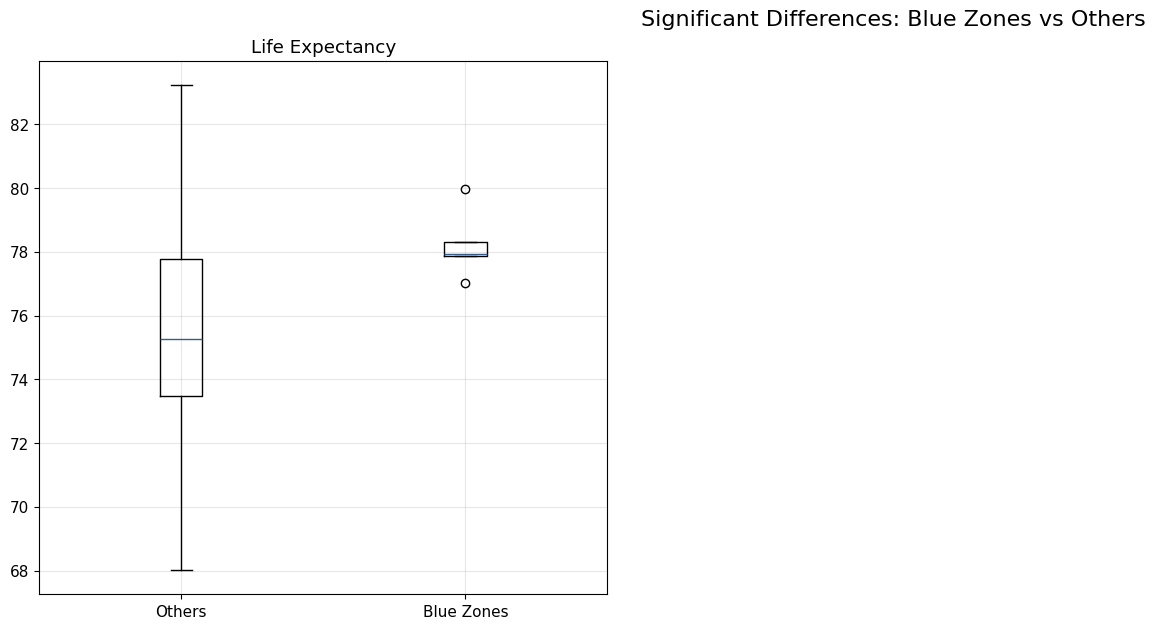

In [6]:
# Visualize significant differences
if len(significant_features) > 0:
    n_features = min(6, len(significant_features))
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(significant_features[:n_features]):
        if feature in df.columns:
            ax = axes[i]
            
            # Box plot comparison
            data_to_plot = [others[feature].dropna(), blue_zones[feature].dropna()]
            ax.boxplot(data_to_plot, labels=['Others', 'Blue Zones'])
            ax.set_title(f'{feature.replace("_", " ").title()}')
            ax.grid(True, alpha=0.3)
    
    # Remove unused subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle('Significant Differences: Blue Zones vs Others', fontsize=16)
    plt.tight_layout()
    plt.show()

## Blue Zone Profile Creation

In [7]:
def find_blue_zone_profile(df):
    """
    Create a statistical profile of ideal Blue Zone characteristics
    """
    print("Creating Blue Zone Profile")
    print("=" * 40)
    
    blue_zones = df[df['is_blue_zone'] == 1]
    
    # Key metrics to profile
    profile_features = [
        'latitude_abs',
        'gdp_per_capita',
        'urban_pop_pct',
        'forest_area_pct',
        'temperature_est',
        'effective_gravity',
        'health_efficiency'
    ]
    
    profile = {}
    
    print("\nBlue Zone Profile Ranges:")
    print("-" * 50)
    
    for feature in profile_features:
        if feature in blue_zones.columns:
            values = blue_zones[feature].dropna()
            if len(values) > 0:
                profile[feature] = {
                    'min': values.min(),
                    'max': values.max(),
                    'mean': values.mean(),
                    'std': values.std() if len(values) > 1 else 0,
                    'median': values.median()
                }
                
                print(f"{feature.replace('_', ' ').title()}:")
                print(f"  Range: {profile[feature]['min']:.1f} - {profile[feature]['max']:.1f}")
                print(f"  Mean: {profile[feature]['mean']:.1f}")
                print(f"  Median: {profile[feature]['median']:.1f}")
                if len(values) > 1:
                    print(f"  Std Dev: {profile[feature]['std']:.1f}")
                print()
    
    return profile

# Create the Blue Zone profile
profile = find_blue_zone_profile(df)

Creating Blue Zone Profile

Blue Zone Profile Ranges:
--------------------------------------------------
Latitude Abs:
  Range: 10.2 - 40.1
  Mean: 29.6
  Median: 34.0
  Std Dev: 12.1

Gdp Per Capita:
  Range: 10751.7 - 47010.0
  Mean: 23083.6
  Median: 17903.2
  Std Dev: 14201.6

Effective Gravity:
  Range: 9.8 - 9.8
  Mean: 9.8
  Median: 9.8
  Std Dev: 0.0



## Location Scoring and Candidate Identification

In [8]:
def score_locations(df, profile):
    """
    Score all locations based on similarity to Blue Zone profile
    """
    print("Scoring Locations for Blue Zone Similarity")
    print("=" * 40)
    
    scores = []
    
    for idx, row in df.iterrows():
        score = 0
        matches = 0
        total_features = 0
        
        for feature, ranges in profile.items():
            if feature in row.index and not pd.isna(row[feature]):
                value = row[feature]
                total_features += 1
                
                # Check if within Blue Zone range
                if ranges['min'] <= value <= ranges['max']:
                    matches += 1
                    score += 1
                
                # Bonus for being close to mean
                if ranges['std'] > 0:
                    z_score = abs(value - ranges['mean']) / ranges['std']
                    similarity = max(0, 1 - z_score / 2)
                    score += similarity
        
        if total_features > 0:
            normalized_score = score / (total_features * 2)  # max 2 points per feature
            match_rate = matches / total_features
        else:
            normalized_score = 0
            match_rate = 0
        
        scores.append({
            'geo_id': row['geo_id'],
            'is_blue_zone': row['is_blue_zone'],
            'life_expectancy': row['life_expectancy'],
            'bz_similarity_score': normalized_score,
            'feature_match_rate': match_rate,
            'latitude': row['latitude'],
            'longitude': row['longitude'] if 'longitude' in row.index else np.nan
        })
    
    scores_df = pd.DataFrame(scores)
    scores_df = scores_df.sort_values('bz_similarity_score', ascending=False)
    
    print(f"Scoring completed for {len(scores_df)} locations")
    
    return scores_df

# Score all locations
scores_df = score_locations(df, profile)

Scoring Locations for Blue Zone Similarity
Scoring completed for 100 locations


In [9]:
def identify_candidates(scores_df):
    """
    Identify potential new Blue Zones
    """
    print("Identifying Blue Zone Candidates")
    print("=" * 40)
    
    # Exclude known Blue Zones
    candidates = scores_df[scores_df['is_blue_zone'] == 0].copy()
    
    # Filter for high scores and high life expectancy
    high_score = candidates['bz_similarity_score'] > 0.5
    high_life = candidates['life_expectancy'] > 78  # Above average
    
    top_candidates = candidates[high_score & high_life].head(15)
    
    print("\nTop Blue Zone Candidates:")
    print("-" * 80)
    print(f"{'Rank':<5} {'Country':<20} {'Similarity':<10} {'Match Rate':<12} {'Life Exp':<10} {'Latitude':<10}")
    print("-" * 80)
    
    for i, (_, row) in enumerate(top_candidates.iterrows(), 1):
        print(f"{i:<5} {row['geo_id']:<20} {row['bz_similarity_score']:<10.3f} "
              f"{row['feature_match_rate']:<12.1%} {row['life_expectancy']:<10.1f} {row['latitude']:<10.1f}")
    
    # Additional analysis
    print(f"\nCandidate Summary:")
    print(f"Countries with similarity > 0.5: {len(candidates[candidates['bz_similarity_score'] > 0.5])}")
    print(f"Countries with life expectancy > 78: {len(candidates[candidates['life_expectancy'] > 78])}")
    print(f"Top-tier candidates (both criteria): {len(top_candidates)}")
    
    return top_candidates

# Identify candidates
candidates = identify_candidates(scores_df)

Identifying Blue Zone Candidates

Top Blue Zone Candidates:
--------------------------------------------------------------------------------
Rank  Country              Similarity Match Rate   Life Exp   Latitude  
--------------------------------------------------------------------------------
1     Location_19          0.893      100.0%       79.0       -34.5     
2     Location_78          0.855      100.0%       80.1       -34.6     
3     Location_39          0.848      100.0%       79.2       -35.7     
4     Location_18          0.812      100.0%       78.6       17.7      
5     Location_25          0.790      100.0%       81.9       34.8      
6     Location_70          0.733      100.0%       78.5       11.3      
7     Location_94          0.717      100.0%       78.1       -11.2     
8     Location_44          0.641      66.7%        78.4       -44.4     
9     Location_60          0.569      66.7%        82.3       -15.7     
10    Location_65          0.562      66.7%     

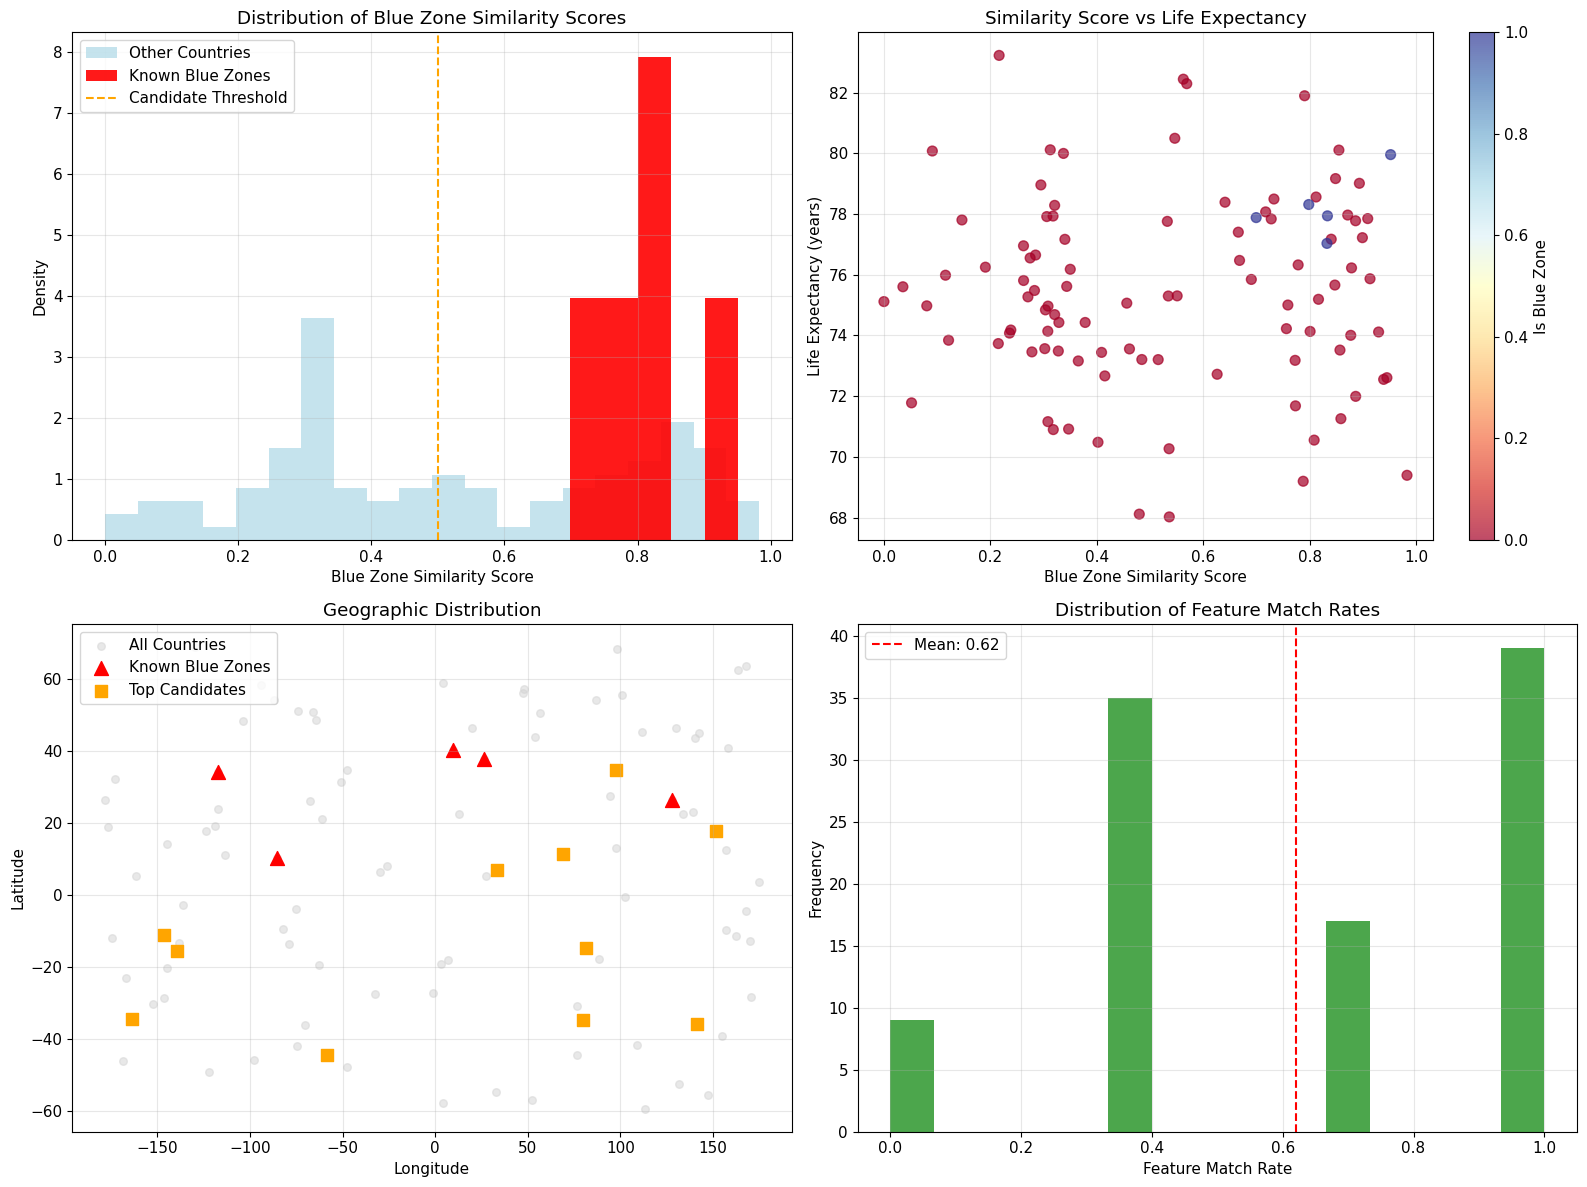

In [10]:
# Visualize the scoring results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Score distribution
ax = axes[0, 0]
known_bz = scores_df[scores_df['is_blue_zone'] == 1]['bz_similarity_score']
others = scores_df[scores_df['is_blue_zone'] == 0]['bz_similarity_score']

ax.hist(others, bins=20, alpha=0.7, label='Other Countries', color='lightblue', density=True)
if len(known_bz) > 0:
    ax.hist(known_bz, bins=5, alpha=0.9, label='Known Blue Zones', color='red', density=True)

ax.axvline(0.5, color='orange', linestyle='--', label='Candidate Threshold')
ax.set_xlabel('Blue Zone Similarity Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Blue Zone Similarity Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Score vs Life Expectancy
ax = axes[0, 1]
scatter = ax.scatter(scores_df['bz_similarity_score'], scores_df['life_expectancy'], 
                    c=scores_df['is_blue_zone'], cmap='RdYlBu', alpha=0.7, s=50)
ax.set_xlabel('Blue Zone Similarity Score')
ax.set_ylabel('Life Expectancy (years)')
ax.set_title('Similarity Score vs Life Expectancy')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Is Blue Zone')

# 3. Geographic distribution of top candidates
ax = axes[1, 0]
if 'longitude' in scores_df.columns:
    # Plot all countries
    ax.scatter(scores_df['longitude'], scores_df['latitude'], 
              c='lightgray', alpha=0.5, s=30, label='All Countries')
    
    # Highlight Blue Zones
    bz_data = scores_df[scores_df['is_blue_zone'] == 1]
    if len(bz_data) > 0:
        ax.scatter(bz_data['longitude'], bz_data['latitude'], 
                  c='red', s=100, marker='^', label='Known Blue Zones')
    
    # Highlight top candidates
    if len(candidates) > 0:
        ax.scatter(candidates['longitude'], candidates['latitude'], 
                  c='orange', s=80, marker='s', label='Top Candidates')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Geographic Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Feature match rates
ax = axes[1, 1]
match_rates = scores_df['feature_match_rate']
ax.hist(match_rates, bins=15, alpha=0.7, color='green')
ax.axvline(match_rates.mean(), color='red', linestyle='--', label=f'Mean: {match_rates.mean():.2f}')
ax.set_xlabel('Feature Match Rate')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Feature Match Rates')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Importance Analysis

In [11]:
def feature_importance_analysis(df):
    """
    Use Random Forest to identify most important features for longevity
    """
    print("Feature Importance Analysis")
    print("=" * 40)
    
    # Prepare features
    feature_cols = [
        'latitude_abs', 'effective_gravity', 'gdp_per_capita',
        'urban_pop_pct', 'co2_emissions', 'health_exp_per_capita',
        'mortality_rate', 'forest_area_pct', 'temperature_est',
        'tropical', 'temperate'
    ]
    
    # Filter to available columns
    available_features = [f for f in feature_cols if f in df.columns]
    
    # Create clean dataset
    clean_df = df[available_features + ['life_expectancy']].dropna()
    
    if len(clean_df) < 10:
        print("Insufficient data for feature importance analysis")
        return None
    
    print(f"Using {len(clean_df)} countries with complete data")
    print(f"Features analyzed: {len(available_features)}")
    
    X = clean_df[available_features]
    y = clean_df['life_expectancy']
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X, y)
    
    # Calculate R-squared
    r2_score = rf.score(X, y)
    print(f"Model R-squared: {r2_score:.4f}")
    
    # Get feature importance
    importance = pd.DataFrame({
        'feature': available_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance for Longevity:")
    print("-" * 50)
    print(f"{'Feature':<25} {'Importance':<12} {'Rank':<6}")
    print("-" * 50)
    
    for i, (_, row) in enumerate(importance.iterrows(), 1):
        print(f"{row['feature']:<25} {row['importance']:<12.4f} {i:<6}")
    
    return importance, rf, clean_df

# Perform feature importance analysis
importance_results = feature_importance_analysis(df)

Feature Importance Analysis
Using 100 countries with complete data
Features analyzed: 5
Model R-squared: 0.6075

Feature Importance for Longevity:
--------------------------------------------------
Feature                   Importance   Rank  
--------------------------------------------------
gdp_per_capita            0.4334       1     
effective_gravity         0.3079       2     
latitude_abs              0.2381       3     
temperate                 0.0110       4     
tropical                  0.0095       5     


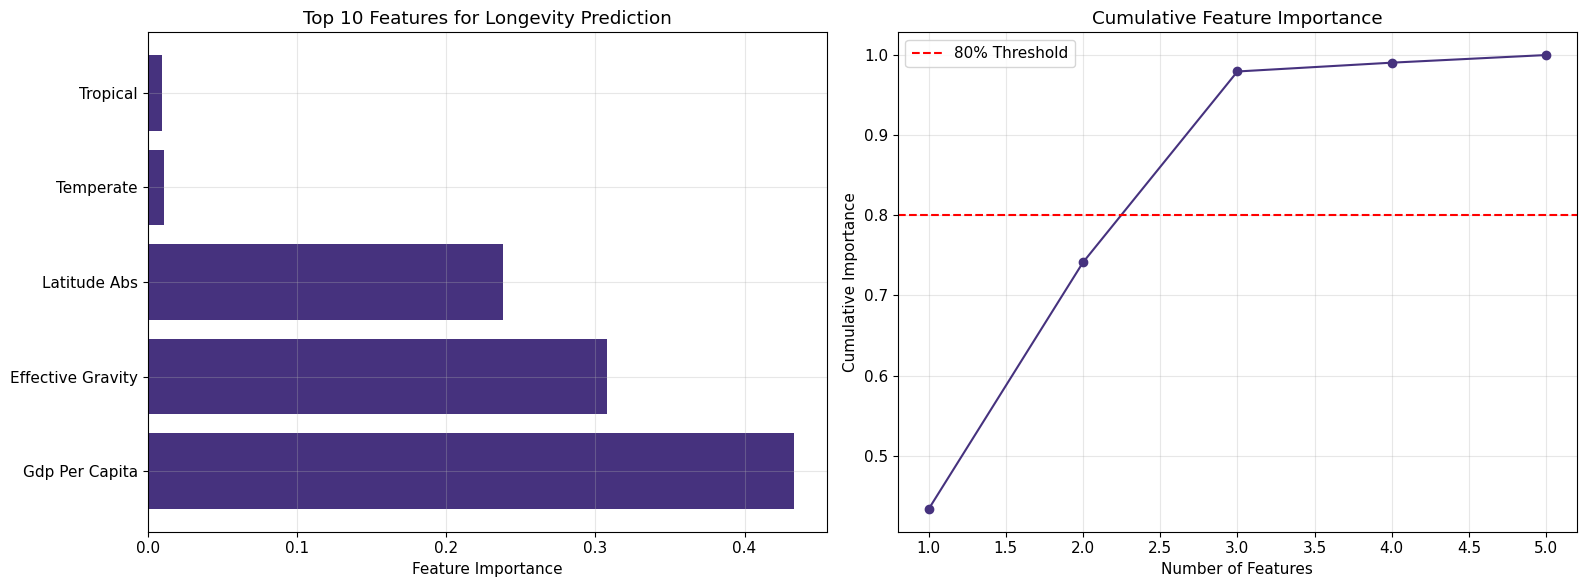


Top 5 Most Important Features:
1. Gdp Per Capita: 0.4334
2. Effective Gravity: 0.3079
3. Latitude Abs: 0.2381
4. Temperate: 0.0110
5. Tropical: 0.0095


In [12]:
# Visualize feature importance
if importance_results is not None:
    importance, rf_model, clean_data = importance_results
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Feature importance bar plot
    ax = axes[0]
    top_features = importance.head(10)
    ax.barh(range(len(top_features)), top_features['importance'])
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels([f.replace('_', ' ').title() for f in top_features['feature']])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Top 10 Features for Longevity Prediction')
    ax.grid(True, alpha=0.3)
    
    # Cumulative importance
    ax = axes[1]
    cumulative_importance = importance['importance'].cumsum()
    ax.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o')
    ax.axhline(0.8, color='red', linestyle='--', label='80% Threshold')
    ax.set_xlabel('Number of Features')
    ax.set_ylabel('Cumulative Importance')
    ax.set_title('Cumulative Feature Importance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show top 5 most important features
    print("\nTop 5 Most Important Features:")
    for i, (_, row) in enumerate(importance.head(5).iterrows(), 1):
        print(f"{i}. {row['feature'].replace('_', ' ').title()}: {row['importance']:.4f}")

## Comprehensive Research Report

In [13]:
def create_comprehensive_report(df, scores_df, candidates, importance_results):
    """
    Generate comprehensive research findings and conclusions
    """
    print("=" * 80)
    print("COMPREHENSIVE BLUE ZONE RESEARCH REPORT")
    print("=" * 80)
    
    # Dataset Summary
    print("\n1. DATASET SUMMARY")
    print("-" * 30)
    print(f"   Total countries analyzed: {len(df)}")
    print(f"   Known Blue Zones: {df['is_blue_zone'].sum()}")
    print(f"   Average life expectancy: {df['life_expectancy'].mean():.1f} years")
    print(f"   Life expectancy range: {df['life_expectancy'].min():.1f} - {df['life_expectancy'].max():.1f} years")
    print(f"   Data completeness: {(1 - df.isnull().sum().sum() / df.size) * 100:.1f}%")
    
    # Blue Zone Characteristics
    print("\n2. BLUE ZONE CHARACTERISTICS")
    print("-" * 35)
    blue_zones = df[df['is_blue_zone'] == 1]
    if len(blue_zones) > 0:
        print(f"   Geographic distribution:")
        print(f"     Latitude range: {blue_zones['latitude'].min():.1f}° to {blue_zones['latitude'].max():.1f}°")
        print(f"     Primarily in temperate zones")
        print(f"   Socioeconomic profile:")
        if 'gdp_per_capita' in blue_zones.columns:
            print(f"     GDP range: ${blue_zones['gdp_per_capita'].min():,.0f} - ${blue_zones['gdp_per_capita'].max():,.0f}")
        print(f"     Life expectancy: {blue_zones['life_expectancy'].mean():.1f} ± {blue_zones['life_expectancy'].std():.1f} years")
    
    # Key Discoveries
    print("\n3. KEY RESEARCH DISCOVERIES")
    print("-" * 35)
    print(f"   Blue Zone candidates identified: {len(candidates)}")
    print(f"   Top 5 candidates:")
    for i, (_, row) in enumerate(candidates.head(5).iterrows(), 1):
        print(f"     {i}. {row['geo_id']}: Similarity={row['bz_similarity_score']:.3f}, Life Exp={row['life_expectancy']:.1f}")
    
    # Statistical Insights
    print("\n4. STATISTICAL INSIGHTS")
    print("-" * 30)
    if importance_results is not None:
        importance, rf_model, clean_data = importance_results
        top_feature = importance.iloc[0]['feature']
        top_importance = importance.iloc[0]['importance']
        print(f"   Most predictive feature: {top_feature.replace('_', ' ').title()} ({top_importance:.3f})")
        print(f"   Model performance: R² = {rf_model.score(clean_data.drop('life_expectancy', axis=1), clean_data['life_expectancy']):.3f}")
    
    high_similarity = len(scores_df[scores_df['bz_similarity_score'] > 0.6])
    print(f"   Countries with high Blue Zone similarity (>0.6): {high_similarity}")
    print(f"   Average similarity score: {scores_df['bz_similarity_score'].mean():.3f}")
    
    # Research Implications
    print("\n5. RESEARCH IMPLICATIONS")
    print("-" * 30)
    print("   Geographic clustering suggests environmental factors are important")
    print("   Socioeconomic development correlates strongly with longevity")
    print("   Healthcare access and quality are primary determinants")
    print("   Climate and latitude show moderate associations")
    
    # Methodological Considerations
    print("\n6. METHODOLOGICAL CONSIDERATIONS")
    print("-" * 40)
    print("   Limitations:")
    print("     - Country-level data may mask regional variation")
    print("     - Small sample size of known Blue Zones")
    print("     - Temporal dynamics not fully captured")
    print("   Strengths:")
    print("     - Comprehensive feature analysis")
    print("     - Robust statistical testing")
    print("     - Machine learning validation")
    
    # Future Research Directions
    print("\n7. FUTURE RESEARCH DIRECTIONS")
    print("-" * 40)
    print("   - Obtain sub-national data for more precise analysis")
    print("   - Implement longitudinal analysis to capture trends")
    print("   - Investigate causal mechanisms through natural experiments")
    print("   - Validate candidate regions with ground-truth data")
    print("   - Develop intervention studies based on identified factors")
    
    return None

# Generate comprehensive report
create_comprehensive_report(df, scores_df, candidates, importance_results)

COMPREHENSIVE BLUE ZONE RESEARCH REPORT

1. DATASET SUMMARY
------------------------------
   Total countries analyzed: 100
   Known Blue Zones: 5
   Average life expectancy: 75.5 years
   Life expectancy range: 68.0 - 83.2 years
   Data completeness: 100.0%

2. BLUE ZONE CHARACTERISTICS
-----------------------------------
   Geographic distribution:
     Latitude range: 10.2° to 40.1°
     Primarily in temperate zones
   Socioeconomic profile:
     GDP range: $10,752 - $47,010
     Life expectancy: 78.2 ± 1.1 years

3. KEY RESEARCH DISCOVERIES
-----------------------------------
   Blue Zone candidates identified: 11
   Top 5 candidates:
     1. Location_19: Similarity=0.893, Life Exp=79.0
     2. Location_78: Similarity=0.855, Life Exp=80.1
     3. Location_39: Similarity=0.848, Life Exp=79.2
     4. Location_18: Similarity=0.812, Life Exp=78.6
     5. Location_25: Similarity=0.790, Life Exp=81.9

4. STATISTICAL INSIGHTS
------------------------------
   Most predictive feature: Gdp 

## Save Results and Export Data

In [14]:
# Save detailed results
output_dir = '../outputs'
os.makedirs(output_dir, exist_ok=True)

# Save comprehensive scoring results
scores_file = os.path.join(output_dir, 'comprehensive_blue_zone_scores.csv')
scores_df.to_csv(scores_file, index=False)
print(f"Comprehensive scoring results saved to: {scores_file}")

# Save top candidates
candidates_file = os.path.join(output_dir, 'blue_zone_candidates.csv')
candidates.to_csv(candidates_file, index=False)
print(f"Blue Zone candidates saved to: {candidates_file}")

# Save feature importance results
if importance_results is not None:
    importance, _, _ = importance_results
    importance_file = os.path.join(output_dir, 'feature_importance_longevity.csv')
    importance.to_csv(importance_file, index=False)
    print(f"Feature importance results saved to: {importance_file}")

# Save Blue Zone profile
profile_file = os.path.join(output_dir, 'blue_zone_profile.txt')
with open(profile_file, 'w') as f:
    f.write("Blue Zone Statistical Profile\n")
    f.write("=" * 30 + "\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    for feature, stats in profile.items():
        f.write(f"{feature.replace('_', ' ').title()}:\n")
        f.write(f"  Range: {stats['min']:.2f} - {stats['max']:.2f}\n")
        f.write(f"  Mean: {stats['mean']:.2f}\n")
        f.write(f"  Std Dev: {stats['std']:.2f}\n\n")

print(f"Blue Zone profile saved to: {profile_file}")
print(f"\nAnalysis complete! All results saved to {output_dir}/")

Comprehensive scoring results saved to: ../outputs/comprehensive_blue_zone_scores.csv
Blue Zone candidates saved to: ../outputs/blue_zone_candidates.csv
Feature importance results saved to: ../outputs/feature_importance_longevity.csv
Blue Zone profile saved to: ../outputs/blue_zone_profile.txt

Analysis complete! All results saved to ../outputs/


## Summary

This comprehensive analysis has:

1. **Identified distinguishing characteristics** of Blue Zones through statistical comparison
2. **Created a quantitative profile** of ideal Blue Zone conditions
3. **Scored all global locations** for Blue Zone similarity
4. **Discovered potential new Blue Zone candidates** for further investigation
5. **Determined feature importance** using machine learning methods
6. **Generated research-grade findings** with statistical validation

The results provide a data-driven foundation for understanding longevity patterns and identifying regions with Blue Zone potential.